In [12]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'babacan_2023_binary'
if not os.path.exists('../../data/models/distortions/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    
grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/{model_family}/{name_split_folder}/{m}.txt'
    return metrics

# Create Dataset
## Combined (Field + Synthetic Data) dataset of 2530 Field (Shreevastava 2021) plus 997 Synthetic (Babacan 2023) Synthetic records (3527 total)


In [13]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv

binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df3 = df1
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [14]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/{model_family}/{name_split_folder}'
    distortions_labels = []

    for distortion, ngrams in filtered_model_ngram.items():
        distortion_ = distortion.replace(" ", "_")
        file_path = f"{output_dir}/{distortion_}.txt"
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
        distortions_labels.append(distortion)
        with open(file_path, "w", encoding="utf-8") as f:
            for ngram, metric_value in sorted_ngrams: 
                f.write(f"{' '.join(ngram)}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No Distortion'}))

### Evaluate functions

In [15]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    if metrics.get('Distortion', 0) > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [16]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=True, clean_punct=True)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=True, clean_punct=True)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tThreshold, accuracy, F1 score:')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [17]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_tv = df3[df3.index % 10 != 0]
print('Train and valid',len(df_tv))
df_valid = df_tv[df_tv.index % 10 == 1]
print('Valid set',len(df_valid))
df_train = df_tv[(df_tv.index % 10 != 0) & (df_tv.index % 10 != 1)]
print('Train set',len(df_train))

splits = [
        (df_train, df_valid)
        #(pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        #(pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        #(pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

Full set 3527
Test set 353
Train and valid 3174
Valid set 353
Train set 2821


In [20]:
def grid_search(splits):
    best_param = None
    best_acc = 0
    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                all_values = []
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                        all_values += list(first_split_acc_any.values())
                    elif i == 2:
                        second_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                        all_values += list(second_split_acc_any.values())
                    elif i == 3:
                        third_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                        all_values += list(third_split_acc_any.values())

                min_value = round(min(all_values),3)
                max_value = round(max(all_values),3)
                mean_value = round(np.mean(all_values),3)

                if best_acc < max_value:
                    best_acc = max_value
                    best_param = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\tMin accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}\tBest accuracy: {best_acc}\tHyper-parameters: {str(best_param)}")

    print(f"Best mean accuracy: {best_acc}\tHyper-parameters: {str(best_param)}")
    return best_param

In [21]:
best_param = grid_search(splits)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5354107648725213 0.632286995515695
		 0.2 0.5920679886685553 0.6538461538461539
		 0.3 0.5892351274787535 0.6214099216710183
		 0.4 0.5580736543909348 0.5714285714285715
		 0.5 0.46742209631728043 0.4337349397590362
		 0.6 0.4164305949008499 0.3439490445859873
		 0.7 0.31444759206798867 0.12949640287769784
		 0.8 0.26628895184135976 0.007662835249042146
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.592	Mean accuracy: 0.445	Best accuracy: 0.592	Hyper-parameters: ('TF-IDF', 1, 90)

N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5354107648725213 0.632286995515695
		 0.2 0.5920679886685553 0.6538461538461539
		 0.3 0.5892351274787535 0.6214099216710183
		 0.4 0.5580736543909348 0.5714285714285715
		 0.5 0.46742209631728043 0.43373

		 0.9 0.49008498583569404 0.47058823529411764
	Min accuracy: 0.49	Max accuracy: 0.711	Mean accuracy: 0.63	Best accuracy: 0.737	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 2
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6515580736543909 0.7875647668393783
		 0.2 0.6543909348441926 0.7889273356401385
		 0.3 0.6798866855524079 0.8007054673721341
		 0.4 0.6940509915014165 0.798507462686567
		 0.5 0.7110481586402266 0.7848101265822786
		 0.6 0.6628895184135978 0.7146282973621102
		 0.7 0.5920679886685553 0.6170212765957447
		 0.8 0.5382436260623229 0.5434173669467787
		 0.9 0.49008498583569404 0.47058823529411764
	Min accuracy: 0.49	Max accuracy: 0.711	Mean accuracy: 0.63	Best accuracy: 0.737	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6515580736543909 0.7875647668393

		 0.2 0.6912181303116147 0.8168067226890756
		 0.3 0.6968838526912181 0.8195615514333896
		 0.4 0.7025495750708215 0.8198970840480275
		 0.5 0.7280453257790368 0.8291814946619217
		 0.6 0.7337110481586402 0.8149606299212597
		 0.7 0.7053824362606232 0.758139534883721
		 0.8 0.6062322946175638 0.6351706036745406
		 0.9 0.5495750708215298 0.5595567867036011
	Min accuracy: 0.55	Max accuracy: 0.734	Mean accuracy: 0.678	Best accuracy: 0.737	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 3
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6912181303116147 0.8168067226890756
		 0.2 0.6912181303116147 0.8168067226890756
		 0.3 0.6968838526912181 0.8195615514333896
		 0.4 0.7025495750708215 0.8198970840480275
		 0.5 0.7280453257790368 0.8291814946619217
		 0.6 0.7337110481586402 0.8149606299212597
		 0.7 0.7053824362606232 0.758139534883721
		 0.8 0.6062322946175638 0.6351706036745406
		 0.9 0.5495750708215298 0.

		 0.9 0.5439093484419264 0.5515320334261838
	Min accuracy: 0.544	Max accuracy: 0.742	Mean accuracy: 0.682	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: TF-IDF
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6940509915014165 0.8187919463087249
		 0.2 0.6940509915014165 0.8187919463087249
		 0.3 0.6997167138810199 0.8215488215488215
		 0.4 0.7025495750708215 0.8205128205128206
		 0.5 0.7223796033994334 0.8268551236749118
		 0.6 0.7422096317280453 0.8246628131021195
		 0.7 0.7110481586402266 0.7713004484304932
		 0.8 0.6260623229461756 0.6615384615384615
		 0.9 0.5439093484419264 0.5515320334261838
	Min accuracy: 0.544	Max accuracy: 0.742	Mean accuracy: 0.682	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: TF-IDF
N-gram max length: 4
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.84828711256

		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.

		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6345609065155807 0.7756521739130435
		 0.2 0.6345609065155807 0.7756521739130435
		 

		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.725	Mean accuracy: 0.556	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7195467422096318 0.8363636363636363
		 0.6 0.7110481586402266 0.8222996515679443
		 0.7 0.5977337110481586 0.635897435897436
		 0.8 0.26912181303116145 0.015267175572519085
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.737	Mean accuracy: 0.612	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: F
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.84828

		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482871125611745
	Min accuracy: 0.737	Max accuracy: 0.737	Mean accuracy: 0.737	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: UF
N-gram max length: 2
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: UF
N-gram max length: 2
N-gram inclusion thresh

		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: UF
N-gram max length: 3
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7110481586402266 0.8305647840531561
		 0.2 0.7195467422096318 0.8347245409015024
		 0.3 0.7365439093484419 0.8404802744425386
		 0.4 0.7422096317280453 0.8336380255941499
		 0.5 0.6543909348441926 0.7288888888888888
		 0.6 0.49291784702549574 0.4750733137829912
		 0.7 0.2719546742209632 0.022813688212927757
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.742	Mean accuracy: 0.54	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: UF
N-gram max length: 3
N-gram

		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7195467422096318 0.8363636363636363
		 0.6 0.7110481586402266 0.8222996515679443
		 0.7 0.5977337110481586 0.635897435897436
		 0.8 0.26912181303116145 0.015267175572519085
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.737	Mean accuracy: 0.612	Best accuracy: 0.742	Hyper-parameters: ('TF-IDF', 4, 90)

N-gram selection metric: UF
N-gram max length: 4
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7252124645892352 0.8401976935749589
		 0.6 0.7082152974504249 0.8245315161839863
		 0.7 0.6827195467422096 0.75
		 0.8 0.40226628895184136 0.31715210355987056
		 0.9 0.26912181303116145 0.015267175572519085
	Min accuracy: 0.269	Max accuracy: 0.737	Mean accur

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482871125611745
	Min accuracy: 0.737	Max accuracy: 0.737	Mean accuracy: 0.737	Best accuracy: 0.81	Hyper-parameters: ('FN', 1, 30)

N-gram selection metric: FN
N-gram max length: 1
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0

	Min accuracy: 0.55	Max accuracy: 0.739	Mean accuracy: 0.682	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7082152974504249 0.8286189683860233
		 0.2 0.7082152974504249 0.8286189683860233
		 0.3 0.7138810198300283 0.8313856427378965
		 0.4 0.7138810198300283 0.8291032148900169
		 0.5 0.7422096317280453 0.8417391304347825
		 0.6 0.7507082152974505 0.8333333333333334
		 0.7 0.7337110481586402 0.7929515418502203
		 0.8 0.6543909348441926 0.6934673366834171
		 0.9 0.5552407932011332 0.5674931129476584
	Min accuracy: 0.555	Max accuracy: 0.751	Mean accuracy: 0.698	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7223796033994334 0.8382838283828384
		 0.2 0.7223796033994334 0.8382838283828384
		 0.3 0.725

		 0.6 0.7648725212464589 0.8605042016806723
		 0.7 0.7932011331444759 0.8670309653916211
		 0.8 0.7762039660056658 0.8271334792122538
		 0.9 0.6203966005665722 0.654639175257732
	Min accuracy: 0.62	Max accuracy: 0.793	Mean accuracy: 0.735	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7393767705382436 0.8496732026143791
		 0.6 0.7393767705382436 0.8496732026143791
		 0.7 0.7535410764872521 0.8552412645590682
		 0.8 0.7988668555240793 0.8697247706422019
		 0.9 0.71671388101983 0.7685185185185186
	Min accuracy: 0.717	Max accuracy: 0.799	Mean accuracy: 0.744	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FN
N-gram max length: 4
N-gram i

		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7478753541076487 0.8524046434494196
	Min accuracy: 0.737	Max accuracy: 0.748	Mean accuracy: 0.738	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: UFN
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8477

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482871125611745
	Min accuracy: 0.737	Max accuracy: 0.737	Mean accuracy: 0.737	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: UFN
N-gram max length: 3
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6940509915014165 0.8187919463087249
		 0.2 0.6940509915014165 0.8187919463087249
		 0.3 0.6997167138810199 0.8215488215488215
		 0.4 0.7053824362606232 0.8219178082191781
		 0.5 0.7252124645892352 0.8283185840707964
		 0.6 0.7393767705382436 0.8196078431372548
		 0.7 0.7110481586402266

	Min accuracy: 0.55	Max accuracy: 0.759	Mean accuracy: 0.699	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: UFN
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7393767705382436 0.8496732026143791
		 0.2 0.7393767705382436 0.8496732026143791
		 0.3 0.7393767705382436 0.8496732026143791
		 0.4 0.7422096317280453 0.8505747126436781
		 0.5 0.7422096317280453 0.8495867768595041
		 0.6 0.7592067988668555 0.8537005163511188
		 0.7 0.7847025495750708 0.8538461538461538
		 0.8 0.7195467422096318 0.7724137931034484
		 0.9 0.5920679886685553 0.6170212765957447
	Min accuracy: 0.592	Max accuracy: 0.785	Mean accuracy: 0.729	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: UFN
N-gram max length: 4
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7

		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.725	Mean accuracy: 0.556	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7195467422096318 0.8363636363636363
		 0.6 0.7110481586402266 0.8222996515679443
		 0.7 0.5977337110481586 0.635897435897436
		 0.8 0.26912181303116145 0.015267175572519085
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.737	Mean accuracy: 0.612	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 1
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.84828711256

		 0.9 0.2804532577903683 0.04511278195488722
	Min accuracy: 0.28	Max accuracy: 0.737	Mean accuracy: 0.665	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 2
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7393767705382436 0.8496732026143791
		 0.8 0.7252124645892352 0.8138195777351247
		 0.9 0.38243626062322944 0.2781456953642384
	Min accuracy: 0.382	Max accuracy: 0.739	Mean accuracy: 0.696	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 2
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.

		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 4
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: CFR
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.65

		 0.9 0.38243626062322944 0.2781456953642384
	Min accuracy: 0.382	Max accuracy: 0.827	Mean accuracy: 0.687	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7308781869688386 0.8445171849427169
		 0.7 0.7450424929178471 0.8489932885906041
		 0.8 0.7960339943342776 0.8506224066390041
		 0.9 0.5382436260623229 0.5434173669467787
	Min accuracy: 0.538	Max accuracy: 0.796	Mean accuracy: 0.721	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0

		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8477905073649754
	Min accuracy: 0.737	Max accuracy: 0.737	Mean accuracy: 0.737	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FCR
N-gram max length: 2
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482871125611745
	Min accuracy: 0.737	Max accurac

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482871125611745
	Min accuracy: 0.737	Max accuracy: 0.737	Mean accuracy: 0.737	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: FCR
N-gram max length: 4
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6968838526912181 0.8207705192629816
		 0.2 0.6968838526912181 0.8207705192629816
		 0.3 0.7025495750708215 0.8235294117647058
		 0.4 0.7082152974504249 0.8245315161839863
		 0.5 0.7223796033994334 0.8280701754385965
		 0.6 0.7535410764872521 0.8336520076481836
		 0.7 0.71671388101983 0

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7110481586402266 0.8305647840531561
		 0.2 0.7195467422096318 0.8347245409015024
		 0.3 0.7365439093484419 0.8404802744425386
		 0.4 0.7422096317280453 0.8336380255941499
		 0.5 0.6543909348441926 0.7288888888888888
		 0.6 0.49291784702549574 0.4750733137829912
		 0.7 0.2719546742209632 0.022813688212927757
		 0.8 

		 0.2 0.7195467422096318 0.8369028006589785
		 0.3 0.7223796033994334 0.8382838283828384
		 0.4 0.7195467422096318 0.8313458262350937
		 0.5 0.7195467422096318 0.8163265306122449
		 0.6 0.6742209631728046 0.7294117647058823
		 0.7 0.4702549575070821 0.4384384384384385
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.722	Mean accuracy: 0.586	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: MR
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7223796033994334 0.8382838283828384
		 0.6 0.7110481586402266 0.8247422680412372
		 0.7 0.6798866855524079 0.7365967365967366
		 0.8 0.38526912181303113 0.2838283828382838
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 

		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7252124645892352 0.8386023294509152
		 0.8 0.7223796033994334 0.7812500000000001
		 0.9 0.35694050991501414 0.22525597269624573
	Min accuracy: 0.357	Max accuracy: 0.737	Mean accuracy: 0.692	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: MR
N-gram max length: 3
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7365439093484419 0.8482871125611745
		 0.8 0.7365439093484419 0.8482871125611745
		 0.9 0.7365439093484419 0.8482

		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	Mean accuracy: 0.474	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.623229461756374 0.763765541740675
		 0.2 0.6402266288951841 0.7711711711711712
		 0.3 0.6572237960339944 0.7712665406427222
		 0.4 0.6685552407932012 0.7536842105263157
		 0.5 0.5354107648725213 0.5494505494505495
		 0.6 0.34277620396600567 0.19444444444444445
		 0.7 0.26912181303116145 0.015267175572519085
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.669	M

		 0.3 0.7365439093484419 0.8404802744425386
		 0.4 0.7422096317280453 0.8336380255941499
		 0.5 0.7025495750708215 0.7751605995717344
		 0.6 0.5552407932011332 0.5674931129476584
		 0.7 0.3626062322946176 0.23728813559322035
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.742	Mean accuracy: 0.562	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: NLMI
N-gram max length: 2
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7195467422096318 0.8369028006589785
		 0.2 0.7195467422096318 0.8369028006589785
		 0.3 0.7223796033994334 0.8382838283828384
		 0.4 0.7195467422096318 0.8313458262350937
		 0.5 0.7195467422096318 0.8163265306122449
		 0.6 0.6742209631728046 0.7294117647058823
		 0.7 0.4702549575070821 0.4384384384384385
		 0.8 0.26345609065155806 0
		 0.9 0.26345609065155806 0
	Min accuracy: 0.263	Max accuracy: 0.722	Mean accuracy: 0.586	Best accuracy: 0.83	Hyper-parame

		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7252124645892352 0.8401976935749589
		 0.6 0.71671388101983 0.8305084745762712
		 0.7 0.7337110481586402 0.8073770491803278
		 0.8 0.49008498583569404 0.47058823529411764
		 0.9 0.3059490084985836 0.1090909090909091
	Min accuracy: 0.306	Max accuracy: 0.737	Mean accuracy: 0.658	Best accuracy: 0.83	Hyper-parameters: ('FN', 2, 60)

N-gram selection metric: NLMI
N-gram max length: 3
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7365439093484419 0.8482871125611745
		 0.2 0.7365439093484419 0.8482871125611745
		 0.3 0.7365439093484419 0.8482871125611745
		 0.4 0.7365439093484419 0.8482871125611745
		 0.5 0.7365439093484419 0.8482871125611745
		 0.6 0.7365439093484419 0.8482871125611745
		 0.7 0.7252124645892352 0.8386023294509152
		 0.8 0.7223796033994334 0.7812500000000001
		 0.9 0.35694050991501414 0.22525597269624573
	Min accuracy: 0.357	Max accu

### Our best model obtained through the optimal combination of hyper-parameters

In [22]:
best_sm, best_nm, best_it = best_param

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN
N-gram max length: 2
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7252124645892352 0.8407224958949098
		 0.2 0.7252124645892352 0.8407224958949098
		 0.3 0.7280453257790368 0.8421052631578947
		 0.4 0.7308781869688386 0.8424543946932007
		 0.5 0.7450424929178471 0.8479729729729729
		 0.6 0.7818696883852692 0.8641975308641975
		 0.7 0.830028328611898 0.8780487804878049
		 0.8 0.7223796033994334 0.7677725118483413
		 0.9 0.5864022662889519 0.6096256684491979


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

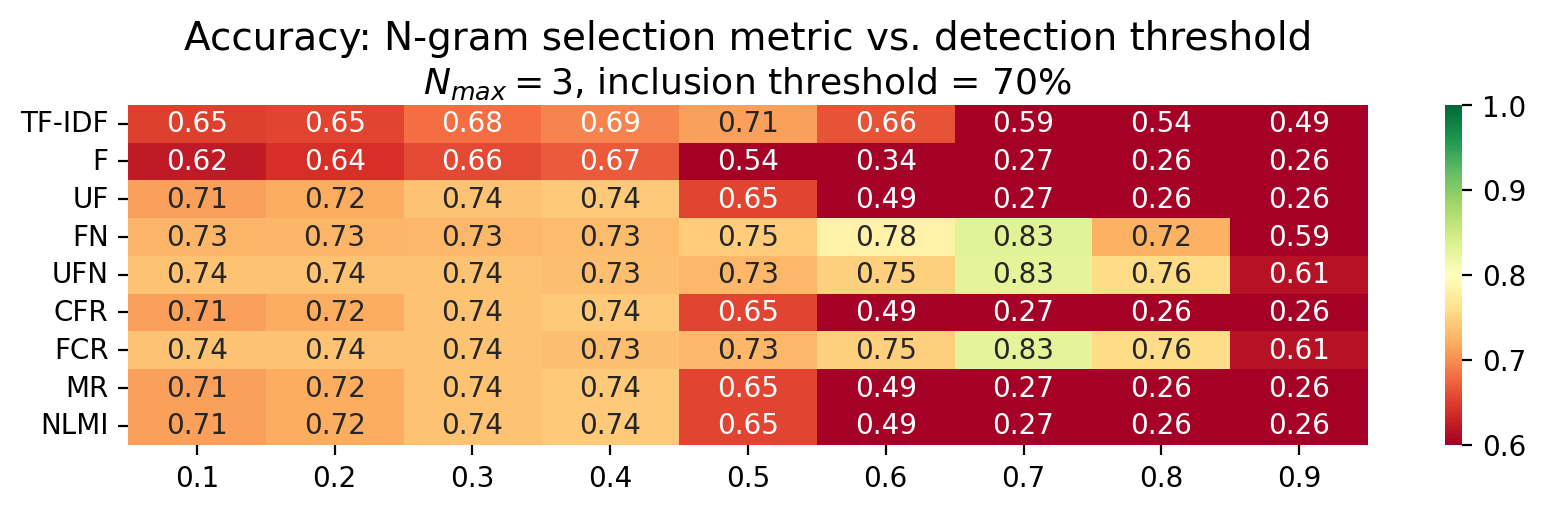

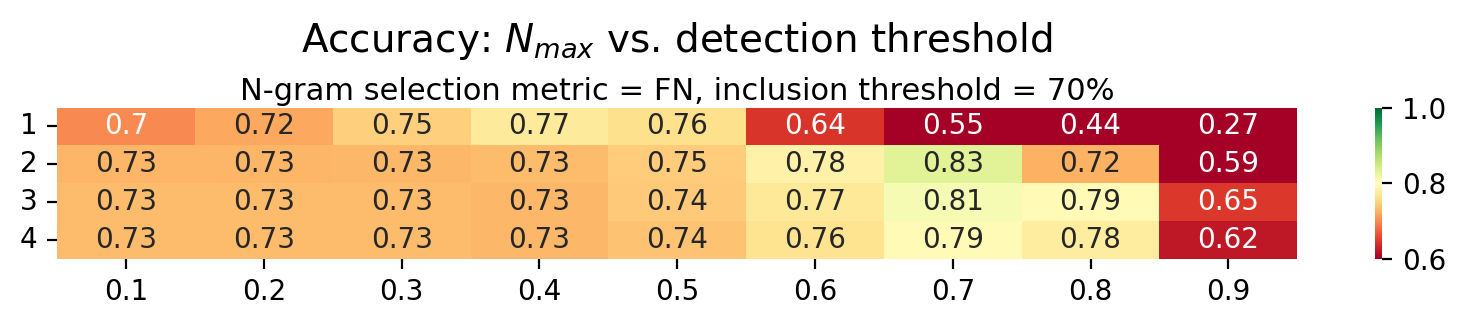

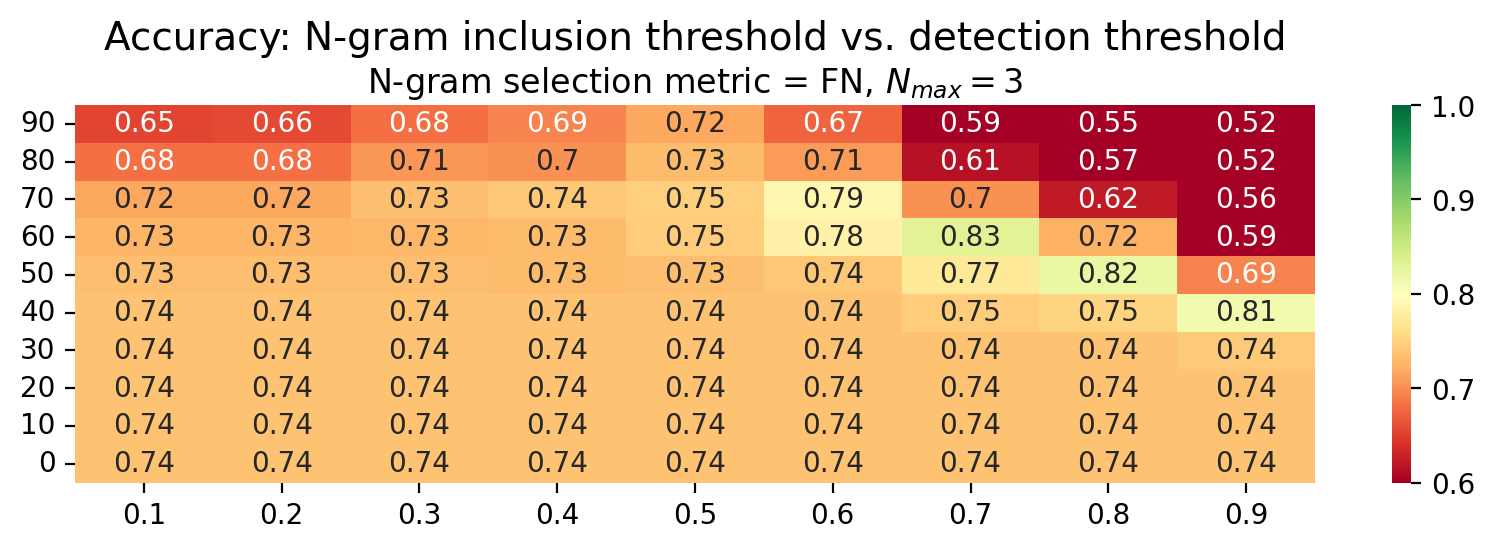

In [23]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key] 
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="$N_{max}=3$, inclusion threshold = 70%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key] 
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="N-gram selection metric = FN, inclusion threshold = 70%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)


# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="N-gram selection metric = FN, $N_{max}=3$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

In [24]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'1 day, 3:36:25.163940'

### Our best model obtained through the optimal combination of hyper-parameters

In [25]:
for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7223796033994334 0.8382838283828384
		 0.2 0.7223796033994334 0.8382838283828384
		 0.3 0.7252124645892352 0.8396694214876034
		 0.4 0.7337110481586402 0.8433333333333333
		 0.5 0.7535410764872521 0.8517887563884157
		 0.6 0.7762039660056658 0.8581687612208257
		 0.7 0.7762039660056658 0.8391038696537677
		 0.8 0.7053824362606232 0.7523809523809524
		 0.9 0.5920679886685553 0.6170212765957447
